# GPU

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")

1 GPU(s) física(s), 1 GPU(s) lógica(s)
Funciona


# Imports

In [ ]:
import transformers
import tensorflow as tf
from tensorflow.keras import layers
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import os 
import requests
from zipfile import ZipFile 
import shutil #To copy the FER2013 and CK+ images to the folder
import pandas as pd #To create dataframe
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split #Split the train, test and val data
from collections import Counter  #To count the amount of labels for each generator
from keras.preprocessing.image import ImageDataGenerator #To create the generator and iterator by dataframe or directory. Also pre-processing
import numpy as np 
import matplotlib.pyplot as plt #Chart
from keras.preprocessing import image 
from keras.callbacks import ModelCheckpoint #to create a checkpoint and save each acc in each epocs that improves
from datetime import datetime #to tensorboard
from tensorflow.keras.callbacks import TensorBoard #to tensorboard
from keras.applications import InceptionResNetV2 
from keras.models import Sequential, Model 
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D 
import PIL

from keras.applications import EfficientNetB0
from keras.layers import BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D, Input
from keras.models import Model
from keras.regularizers import L2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [ ]:
import random, os
import numpy as np
#import tensorflow as tf

#SET SEED
def set_seed(seed=42):
  np.random.seed(seed) 
  tf.random.set_seed(seed) 
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Data Augmentation

In [ ]:
img_shape = 48
BATCH_SIZE = 32 #It is carried out in 32 batch size by computational power for VIT models.

train_dir = 'fer2013/train'
test_dir = 'fer2013/test'

train_datagen = ImageDataGenerator(
    rescale=1/255,    #Normalization            
    rotation_range=10,   #rotation range between -10 to 10
    zoom_range=0.2,      #zoom range       
    width_shift_range=0.1,   # width shift range     
    height_shift_range=0.1,  # height shift range         
    horizontal_flip=True,    # horizontal flip in true     
    fill_mode='nearest',          
    validation_split=0.2    #train is divided into 20% for validation      
)

val_datagen = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             # transform to rgb images
    class_mode='categorical',     # apply One Hot Encoder
    batch_size=BATCH_SIZE,                # 64 batch
    seed = 42,
    subset="training",            #Training set  
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),   #48x48    
    color_mode='rgb',             # transform to rgb images
    class_mode='categorical',     # apply One Hot Encoder
    batch_size=BATCH_SIZE,                # 64 batch 
    seed = 42,
    subset="validation",    #validation set        
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),   #48x48    
    color_mode='rgb',             # transform to rgb images
    class_mode='categorical',     # apply One Hot Encoder
    batch_size=BATCH_SIZE,                # 64 batch 
    seed = 42,
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


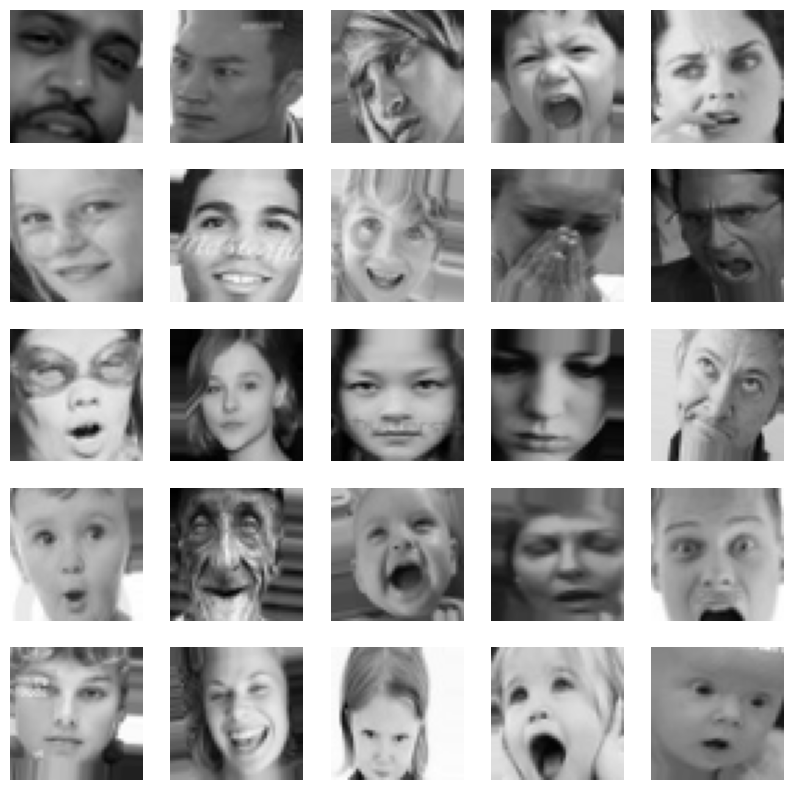

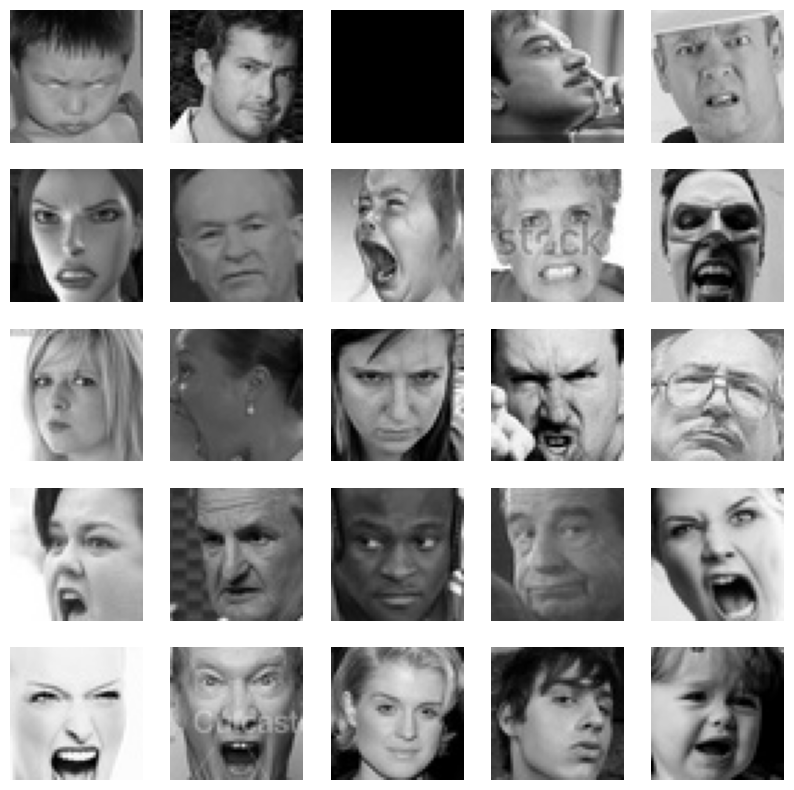

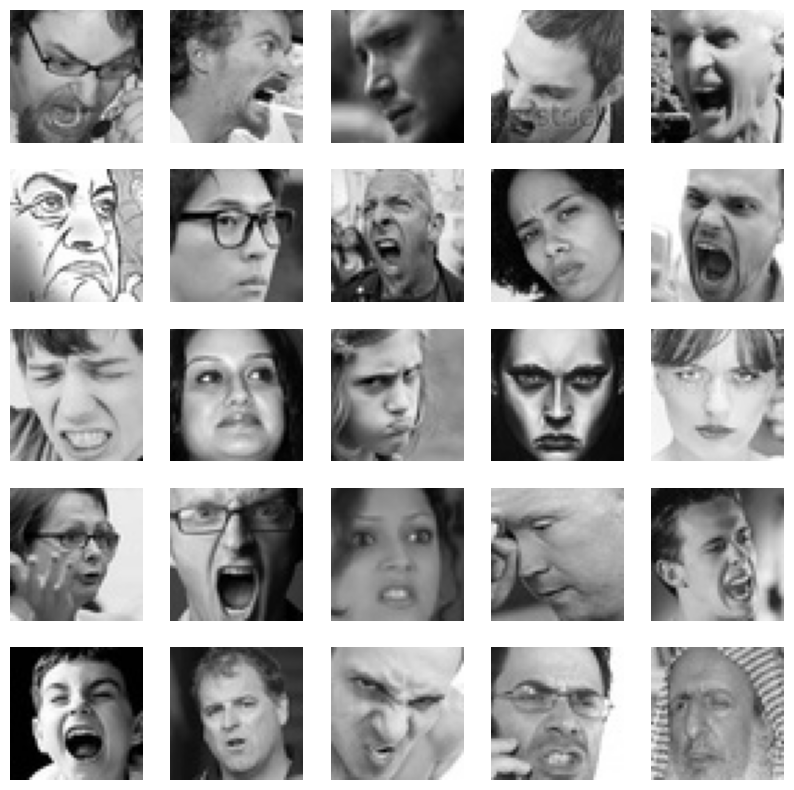

In [ ]:
# Function for diplay images
def mostrar_imagenes(generator, num_images):
    images, labels = next(generator)
    
    plt.figure(figsize=(10, 10))
    
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])  
        plt.axis('off')
    
    plt.show()

mostrar_imagenes(train_generator, 25)
mostrar_imagenes(val_generator, 25)
mostrar_imagenes(test_generator, 25)

# Definition of importance by classes (balancing) in the train set

In [ ]:

classes = np.array(train_generator.classes)

# balancing by weighted weights 
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(classes),  
    y=classes  
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


# VIT Model Transformers

## Configuration Vit 

In [ ]:
from transformers import ViTModel, ViTConfig


configuration = ViTConfig() #Import configuration of the Vit Model

model = ViTModel(configuration) #Application of configurations

configuration = model.config

In [7]:
print(configuration)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.40.0"
}



## Import and definition model Google Vit patch16-244

In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel

model_vit = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k') #Import pre-trained Vit Model - Google Vit patch16-224

for layer in model_vit.layers:
    layer.trainable = False #All pre-trained layers set to False

model_vit.summary

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


<bound method Model.summary of <transformers.models.vit.modeling_tf_vit.TFViTModel object at 0x000002BA9587C790>>

## Model 1 vit-base-patch16-224-in21k BASE 

In [ ]:
from keras.optimizers import Adam

inputs = layers.Input(shape=(48, 48, 3))

x = layers.Resizing(224,224)(inputs) #Function to resize images to 224x224. Size required by ViT model
x = layers.Permute((3, 1, 2))(x)  #Function to change order of dimensions required by Vit Model, with color channel first and then size (3,224,244)

x = model_vit.vit(x)[0][:,0,:] # It processes the input through the model, then extracts the output from the model and selects the class token corresponding to each image in the batch
output = layers.Dense(7, activation="softmax")(x) # Output layer
modelVit1 = tf.keras.Model(inputs=inputs, outputs=output) #Definition of model input and output

modelVit1.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"]) #compilation

modelVit1.layers[3].trainable = False  #Layer the Vit model in False to avoid retraining it and take advantage of its capabilities


modelVit1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 permute (Permute)           (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                   

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # to stop the model when it stops learning



#--------------------Checkpoint--------------------

os.makedirs('models/VitTransformers/64batch', exist_ok=True)


checkpoint_path = 'models/VitTransformers/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/VitTransformers/64batch', exist_ok=True)



log_dir = "logs/VitTransformers/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

In [9]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

training the model

In [ ]:
historyVit1 = modelVit1.fit(train_generator,epochs = 300,validation_data = val_generator, class_weight=class_weights_dict, callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)
#The model uses the weights balanced for each class

Epoch 1/300
718/718 [==============================] - ETA: 0s - loss: 1.8440 - accuracy: 0.3206
Epoch 1: val_accuracy improved from -inf to 0.42675, saving model to models/VitTransformers/64batch\best_model_ModelPaper2_1_0.4268.h5
718/718 [==============================] - 292s 388ms/step - loss: 1.8440 - accuracy: 0.3206 - val_loss: 1.6863 - val_accuracy: 0.4268 - lr: 1.0000e-04
Epoch 2/300
718/718 [==============================] - ETA: 0s - loss: 1.6888 - accuracy: 0.4461
Epoch 2: val_accuracy improved from 0.42675 to 0.45584, saving model to models/VitTransformers/64batch\best_model_ModelPaper2_2_0.4558.h5
718/718 [==============================] - 281s 391ms/step - loss: 1.6888 - accuracy: 0.4461 - val_loss: 1.5809 - val_accuracy: 0.4558 - lr: 1.0000e-04
Epoch 3/300
718/718 [==============================] - ETA: 0s - loss: 1.6121 - accuracy: 0.4611
Epoch 3: val_accuracy improved from 0.45584 to 0.47361, saving model to models/VitTransformers/64batch\best_model_ModelPaper2_3_0.47

In [15]:
def custom_object_vit():
    return {'TFViTMainLayer': TFViTModel}


modelVit1load = tf.keras.models.load_model(r'models/VitTransformers/64batch\best_model_ModelPaper2_18_0.5186.h5', custom_objects=custom_object_vit())
modelVit1load.evaluate(test_generator)

225/225 [==============================] - 76s 325ms/step - loss: 1.3186 - accuracy: 0.5167


[1.3186378479003906, 0.5167177319526672]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Get all classes of y_test
y_pred = modelVit1load.predict(test_generator).argmax(axis=1) 

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

225/225 [==============================] - 65s 273ms/step
              precision    recall  f1-score   support

           0       0.38      0.37      0.38       958
           1       0.10      0.44      0.16       111
           2       0.39      0.23      0.28      1024
           3       0.83      0.74      0.78      1774
           4       0.47      0.57      0.52      1233
           5       0.47      0.34      0.39      1247
           6       0.52      0.76      0.62       831

    accuracy                           0.52      7178
   macro avg       0.45      0.49      0.45      7178
weighted avg       0.54      0.52      0.52      7178

<function confusion_matrix at 0x000002BA93279240>


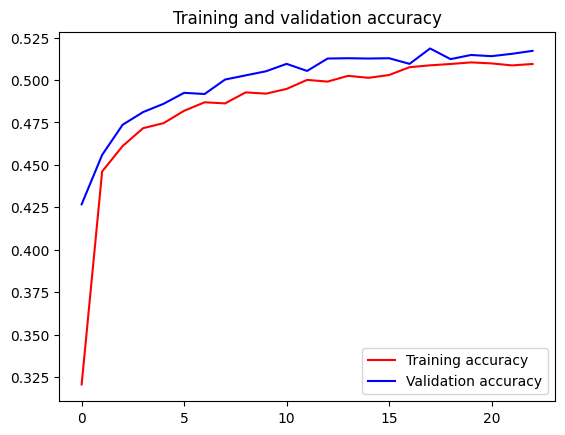

<Figure size 640x480 with 0 Axes>

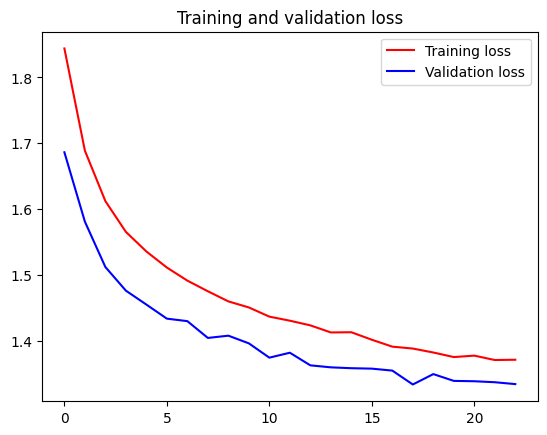

In [11]:
import matplotlib.pyplot as plt
accuracy = historyVit1.history['accuracy']
val_acc = historyVit1.history['val_accuracy']
loss = historyVit1.history['loss']
val_loss = historyVit1.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 2 vit-base-patch16-224-in21k + Dense Layer 512 neurons

In [ ]:
inputs = layers.Input(shape=(48, 48, 3))

x = layers.Resizing(224,224)(inputs) #Function to resize images to 224x224. Size required by ViT model
x = layers.Permute((3, 1, 2))(x)  #Function to change order of dimensions required by Vit Model, with color channel first and then size (3,224,244)

x = model_vit.vit(x)[0][:,0,:] # It processes the input through the model, then extracts the output from the model and selects the class token corresponding to each image in the batch
x = layers.Dense(512, activation="relu")(x) # Dense layer for training
output = layers.Dense(7, activation="softmax")(x) # Output layer
modelVit2 = tf.keras.Model(inputs=inputs, outputs=output) #Definition of model input and output

modelVit2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"]) #Compilation

modelVit2.layers[3].trainable = False #Layer the Vit model in False to avoid retraining it and take advantage of its capabilities


modelVit2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 permute_1 (Permute)         (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                 

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # to stop the model when it stops learning



#--------------------Checkpoint--------------------

os.makedirs('models/VitTransformers2/64batch', exist_ok=True)


checkpoint_path = 'models/VitTransformers2/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/VitTransformers2/64batch', exist_ok=True)



log_dir = "logs/VitTransformers2/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [19]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

Training the model

In [ ]:
historyVit2 = modelVit2.fit(train_generator,epochs = 300,validation_data = val_generator, class_weight=class_weights_dict, callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)
#The model uses the weights balanced for each class

Epoch 1/300
718/718 [==============================] - ETA: 0s - loss: 1.4566 - accuracy: 0.4700
Epoch 1: val_accuracy improved from -inf to 0.50444, saving model to models/VitTransformers2/64batch\best_model_ModelPaper2_1_0.5044.h5
718/718 [==============================] - 338s 455ms/step - loss: 1.4566 - accuracy: 0.4700 - val_loss: 1.3100 - val_accuracy: 0.5044 - lr: 0.0010
Epoch 2/300
718/718 [==============================] - ETA: 0s - loss: 1.3188 - accuracy: 0.5150
Epoch 2: val_accuracy improved from 0.50444 to 0.53701, saving model to models/VitTransformers2/64batch\best_model_ModelPaper2_2_0.5370.h5
718/718 [==============================] - 274s 382ms/step - loss: 1.3188 - accuracy: 0.5150 - val_loss: 1.2197 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 3/300
718/718 [==============================] - ETA: 0s - loss: 1.2432 - accuracy: 0.5360
Epoch 3: val_accuracy did not improve from 0.53701
718/718 [==============================] - 272s 379ms/step - loss: 1.2432 - accuracy: 0

In [25]:
modelVit2_load = tf.keras.models.load_model(r'models/VitTransformers2/64batch\best_model_ModelPaper2_10_0.5887.h5', custom_objects=custom_object_vit())
modelVit2_load.evaluate(test_generator)

225/225 [==============================] - 64s 272ms/step - loss: 1.0877 - accuracy: 0.5992


[1.0877306461334229, 0.5991919636726379]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Get all classes of y_test
y_pred = modelVit2_load.predict(test_generator).argmax(axis=1) 

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

225/225 [==============================] - 64s 272ms/step
              precision    recall  f1-score   support

           0       0.42      0.58      0.49       958
           1       0.37      0.42      0.39       111
           2       0.48      0.32      0.39      1024
           3       0.86      0.79      0.82      1774
           4       0.58      0.62      0.60      1233
           5       0.50      0.47      0.48      1247
           6       0.66      0.75      0.71       831

    accuracy                           0.60      7178
   macro avg       0.55      0.56      0.55      7178
weighted avg       0.61      0.60      0.60      7178

<function confusion_matrix at 0x000002BA93279240>


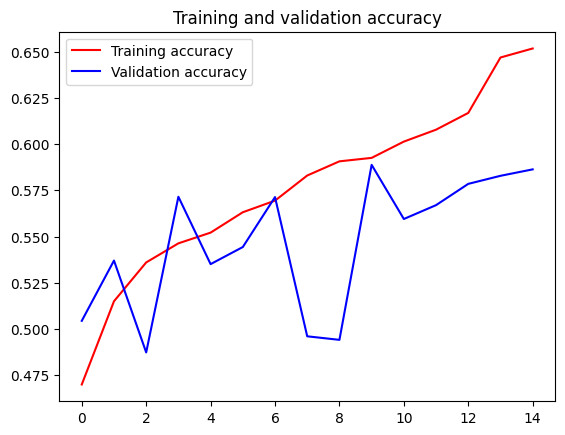

<Figure size 640x480 with 0 Axes>

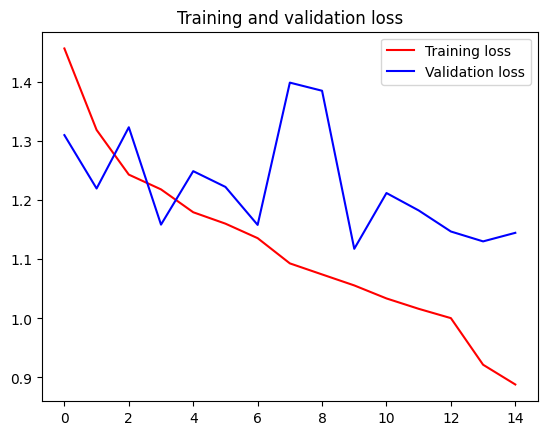

In [21]:
import matplotlib.pyplot as plt
accuracy = historyVit2.history['accuracy']
val_acc = historyVit2.history['val_accuracy']
loss = historyVit2.history['loss']
val_loss = historyVit2.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

# With 2 datasets FER2013 and CK+48

## Data augmentation and definition of importance by classes (balancing) in the train set

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir= 'concatenatedFERandCK'
test_dir = 'fer2013/test'
img_shape = 48

train_datagen = ImageDataGenerator(
    rescale=1/255,    #Normalization            
    rotation_range=10,   #rotation range between -10 to 10
    zoom_range=0.2,      #zoom range       
    width_shift_range=0.1,   # width shift range     
    height_shift_range=0.1,  # height shift range         
    horizontal_flip=True,    # horizontal flip in true     
    fill_mode='nearest',          
    validation_split=0.2    #train is divided into 20% for validation      
)

val_datagen = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             # transform to rgb images
    class_mode='categorical',     # apply One Hot Encoder
    batch_size=64,                # 64 batch
    seed = 42,
    subset="training",            #Training set  
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),   #48x48    
    color_mode='rgb',             # transform to rgb images
    class_mode='categorical',     # apply One Hot Encoder
    batch_size=64,                # 64 batch 
    seed = 42,
    subset="validation",    #validation set        
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),   #48x48    
    color_mode='rgb',             # transform to rgb images
    class_mode='categorical',     # apply One Hot Encoder
    batch_size=64,                # 64 batch 
    seed = 42,
    shuffle=False
)




classes = np.array(train_generator.classes)

# balancing by weighted weights 
class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)


class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Found 23711 images belonging to 7 classes.
Found 5925 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights Dictionary: {0: 1.025207540643376, 1: 6.898748908932208, 2: 1.0147650432251991, 3: 0.570442188326998, 4: 0.8527909653287297, 5: 0.8614663566342101, 6: 1.2380430242272347}


## Configuration VIT

In [ ]:
from transformers import ViTModel, ViTConfig


configuration = ViTConfig() #Import configuration of the Vit Model

model = ViTModel(configuration) #Application of configurations

configuration = model.config

In [8]:
configuration

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.40.0"
}

## Imports and definitions Google 

In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel

model_vit = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k') #Import pre-trained Vit Model - Google Vit patch16-224

for layer in model_vit.layers:
    layer.trainable = False #All pre-trained layers set to False

model_vit.summary

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


<bound method Model.summary of <transformers.models.vit.modeling_tf_vit.TFViTModel object at 0x0000020799742E30>>

## Model 1 vit-base-patch16-224-in21k BASE 


In [ ]:
from keras.optimizers import Adam

inputs = layers.Input(shape=(48, 48, 3))

x = layers.Resizing(224,224)(inputs) #Function to resize images to 224x224. Size required by ViT model
x = layers.Permute((3, 1, 2))(x)  #Function to change order of dimensions required by Vit Model, with color channel first and then size (3,224,244)

x = model_vit.vit(x)[0][:,0,:] # It processes the input through the model, then extracts the output from the model and selects the class token corresponding to each image in the batch
output = layers.Dense(7, activation="softmax")(x) # Output layer
modelVit1 = tf.keras.Model(inputs=inputs, outputs=output) #Definition of model input and output

modelVit1.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"]) #compilation

modelVit1.layers[3].trainable = False  #Layer the Vit model in False to avoid retraining it and take advantage of its capabilities


modelVit1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 permute (Permute)           (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                   

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # to stop the model when it stops learning


#--------------------Checkpoint--------------------

os.makedirs('modelsWith2Datasets/VitTransformers/64batch', exist_ok=True)


checkpoint_path = 'modelsWith2Datasets/VitTransformers/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logsWith2Datasets/VitTransformers/64batch', exist_ok=True)



log_dir = "logsWith2Datasets/VitTransformers/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

training the model

In [ ]:
historyVit1 = modelVit1.fit(train_generator,epochs = 300,validation_data = val_generator, class_weight=class_weights_dict, callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)
#The model uses the weights balanced for each class

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 1.8755 - accuracy: 0.2801
Epoch 1: val_accuracy improved from -inf to 0.40759, saving model to modelsWith2Datasets/VitTransformers/64batch\best_model_ModelPaper2_1_0.4076.h5
371/371 [==============================] - 351s 897ms/step - loss: 1.8755 - accuracy: 0.2801 - val_loss: 1.7416 - val_accuracy: 0.4076 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 1.7397 - accuracy: 0.4177
Epoch 2: val_accuracy improved from 0.40759 to 0.44641, saving model to modelsWith2Datasets/VitTransformers/64batch\best_model_ModelPaper2_2_0.4464.h5
371/371 [==============================] - 270s 727ms/step - loss: 1.7397 - accuracy: 0.4177 - val_loss: 1.6342 - val_accuracy: 0.4464 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 1.6616 - accuracy: 0.4478
Epoch 3: val_accuracy improved from 0.44641 to 0.45654, saving model to modelsWith2Datasets/VitTransformer

In [15]:
modelVit1.evaluate(test_generator)

113/113 [==============================] - 120s 1s/step - loss: 1.2791 - accuracy: 0.5258


[1.2791391611099243, 0.5257731676101685]

In [23]:
def custom_object_vit():
    return {'TFViTMainLayer': TFViTModel}


modelVit1load = tf.keras.models.load_model(r'modelsWith2Datasets/VitTransformers/64batch\best_model_ModelPaper2_39_0.5386.h5', custom_objects=custom_object_vit())
modelVit1load.evaluate(test_generator)

113/113 [==============================] - 62s 521ms/step - loss: 1.2791 - accuracy: 0.5258


[1.2791391611099243, 0.5257731676101685]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Get all classes of y_test
y_pred = modelVit1.predict(test_generator).argmax(axis=1) 

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 62s 515ms/step
              precision    recall  f1-score   support

           0       0.40      0.41      0.40       958
           1       0.10      0.42      0.16       111
           2       0.40      0.22      0.28      1024
           3       0.83      0.75      0.79      1774
           4       0.49      0.57      0.53      1233
           5       0.47      0.34      0.39      1247
           6       0.54      0.77      0.63       831

    accuracy                           0.53      7178
   macro avg       0.46      0.50      0.46      7178
weighted avg       0.54      0.53      0.52      7178

<function confusion_matrix at 0x0000020797A28C10>


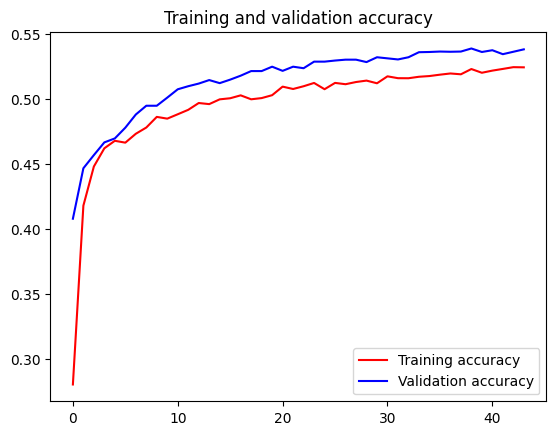

<Figure size 640x480 with 0 Axes>

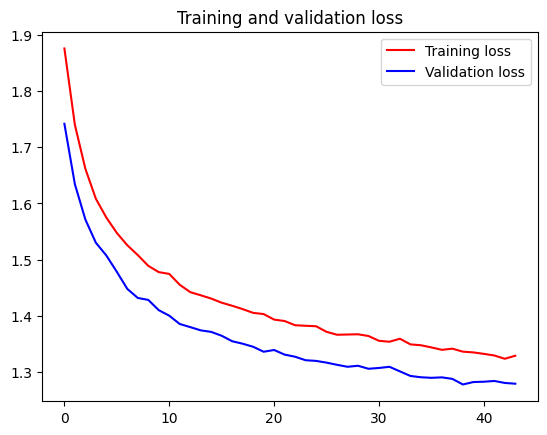

In [14]:
import matplotlib.pyplot as plt
accuracy = historyVit1.history['accuracy']
val_acc = historyVit1.history['val_accuracy']
loss = historyVit1.history['loss']
val_loss = historyVit1.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 2 vit-base-patch16-224-in21k + Dense Layer 512 neurons

In [ ]:
inputs = layers.Input(shape=(48, 48, 3))

x = layers.Resizing(224,224)(inputs) #Function to resize images to 224x224. Size required by ViT model
x = layers.Permute((3, 1, 2))(x)  #Function to change order of dimensions required by Vit Model, with color channel first and then size (3,224,244)

x = model_vit.vit(x)[0][:,0,:] # It processes the input through the model, then extracts the output from the model and selects the class token corresponding to each image in the batch
x = layers.Dense(512, activation="relu")(x) #Dense layer for training
output = layers.Dense(7, activation="softmax")(x) #output layer
modelVit2 = tf.keras.Model(inputs=inputs, outputs=output) #Definition of model input and output

modelVit2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"]) #compilation

modelVit2.layers[3].trainable = False #Layer the Vit model in False to avoid retraining it and take advantage of its capabilities


modelVit2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 permute_1 (Permute)         (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                 

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # to stop the model when it stops learning



#--------------------Checkpoint--------------------

os.makedirs('modelsWith2Datasets/VitTransformers2/64batch', exist_ok=True)


checkpoint_path = 'modelsWith2Datasets/VitTransformers2/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logsWith2Datasets/VitTransformers2/64batch', exist_ok=True)



log_dir = "logsWith2Datasets/VitTransformers2/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


training the model

In [ ]:
historyVit2 = modelVit2.fit(train_generator,epochs = 300,validation_data = val_generator, class_weight=class_weights_dict, callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)
#The model uses the weights balanced for each class

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 1.4471 - accuracy: 0.4690
Epoch 1: val_accuracy improved from -inf to 0.55629, saving model to modelsWith2Datasets/VitTransformers2/64batch\best_model_ModelPaper2_1_0.5563.h5
371/371 [==============================] - 290s 748ms/step - loss: 1.4471 - accuracy: 0.4690 - val_loss: 1.2101 - val_accuracy: 0.5563 - lr: 0.0010
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 1.3019 - accuracy: 0.5170
Epoch 2: val_accuracy did not improve from 0.55629
371/371 [==============================] - 266s 716ms/step - loss: 1.3019 - accuracy: 0.5170 - val_loss: 1.2858 - val_accuracy: 0.5181 - lr: 0.0010
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 1.2416 - accuracy: 0.5374
Epoch 3: val_accuracy improved from 0.55629 to 0.56962, saving model to modelsWith2Datasets/VitTransformers2/64batch\best_model_ModelPaper2_3_0.5696.h5
371/371 [==============================] - 268s 721ms/step - 

In [21]:
modelVit2.evaluate(test_generator)

113/113 [==============================] - 62s 546ms/step - loss: 1.1433 - accuracy: 0.5644


[1.1432791948318481, 0.5643633604049683]

In [24]:
def custom_object_vit():
    return {'TFViTMainLayer': TFViTModel}


modelVit2load = tf.keras.models.load_model(r'modelsWith2Datasets/VitTransformers2/64batch\best_model_ModelPaper2_8_0.5742.h5', custom_objects=custom_object_vit())
modelVit2load.evaluate(test_generator)

113/113 [==============================] - 63s 527ms/step - loss: 1.1433 - accuracy: 0.5644


[1.1432791948318481, 0.5643633604049683]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Get all classes of y_test
y_pred = modelVit2.predict(test_generator).argmax(axis=1) 

report2 = classification_report(y_true, y_pred)
print(report2)

matrix2 = confusion_matrix(y_true, y_pred)
print(matrix2)

113/113 [==============================] - 61s 515ms/step
              precision    recall  f1-score   support

           0       0.43      0.42      0.42       958
           1       0.19      0.47      0.27       111
           2       0.40      0.38      0.39      1024
           3       0.84      0.80      0.82      1774
           4       0.50      0.65      0.56      1233
           5       0.54      0.30      0.38      1247
           6       0.63      0.74      0.68       831

    accuracy                           0.56      7178
   macro avg       0.50      0.54      0.50      7178
weighted avg       0.57      0.56      0.56      7178

[[ 405   59  131   73  159   68   63]
 [  18   52    6    6   17    9    3]
 [ 135   49  390   49  144  103  154]
 [  57   23   43 1417  133   34   67]
 [  79   25  119   61  800   92   57]
 [ 213   56  214   59  309  372   24]
 [  41    7   79   30   49   10  615]]


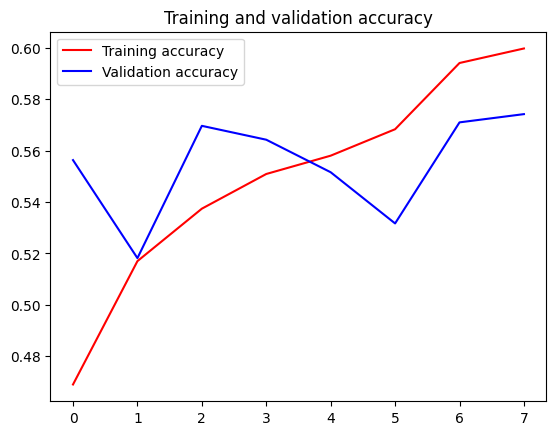

<Figure size 640x480 with 0 Axes>

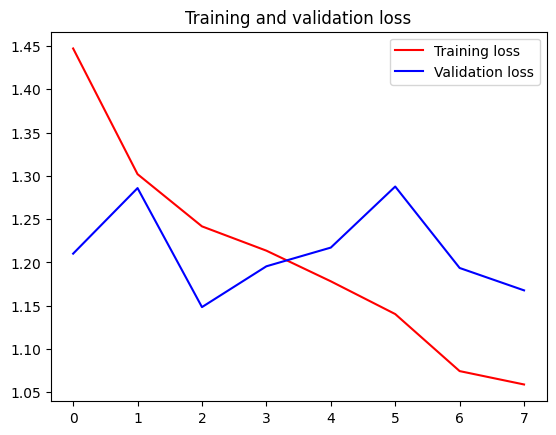

In [20]:
import matplotlib.pyplot as plt
accuracy = historyVit2.history['accuracy']
val_acc = historyVit2.history['val_accuracy']
loss = historyVit2.history['loss']
val_loss = historyVit2.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()